In [3]:
import ndex2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import igraph
import networkx as nx
from random import randint
from cyjupyter import Cytoscape
from timeit import default_timer as timer
from operator import itemgetter

import io
import requests
import pandas as pd

%matplotlib inline


## get test networks from NDEx in as edge tables in csv format

In [4]:
# This is used to prompt users for NDEx credentials in this notebook
#import getpass

In [5]:
# Watch out for typos and be sure to hit enter in the field to set the value!!!
#NDEXUSER = getpass.getpass()
NDEXUSER = "dexterpratt"

In [6]:
# Watch out for typos and be sure to hit enter in the field to set the value!!!
# NDEXPASSWORD = getpass.getpass()
NDEXPASSWORD = "cytoscaperules"
SERVER = "http://www.ndexbio.org"

In [8]:
# TODO: catch server errors, network not found, be graceful
def get_network_as_edge_table(uuid, server=SERVER):
    edge_url = server+'/v3/networks/'+uuid+'/export?type=edge'
    #print(edge_url)
    r = requests.get(edge_url)
    df = pd.read_csv(io.StringIO(r.text),sep='\t')
    return df[["source_id", "target_id"]]

### Get an edge table from the NDEx test server or from a CX file

In [114]:
test_uuid = "d1258a93-c81c-11eb-9060-0660b7976219"
edges = get_network_as_edge_table(test_uuid, "https://test.ndexbio.org")
edges

,source_id,target_id
0,7,1
1,16,17
2,16,1
3,17,1
4,18,16
...,...,...
141,56,30
142,1,56
143,59,61
144,61,58


### Energy Fields
 - An energy field is a square numpy array with an odd number dimension.
 - We define it by its "radius", r, such that the field function is symetric around a center coordinate of (r+1,r+1)
 - The energy in a repulsion field falls off as the square of the distance from the center
 - The energy in an attraction field increases linearly with distance from the center
 - A "gameboard" is the field in which the network can be arranged, initialized to zeros.
 - The area of the gameboard is based on the number of nodes times a scaling factor, "sparsity".
 - Low values of sparsity lead to layouts in which the network shape is strongly influenced by the boundaries of the gameboard. High values lead to greater memory consumption and computation time.

In [264]:
def repulsion_field(radius, scale=1, dtype=np.int32, center_spike=False):
    dimension = (2*radius)+1
    ef = np.zeros((dimension, dimension), dtype=dtype)
    energy = int(scale * radius)
    center_energy = 1000 if center_spike == True else energy
    for x in range(0, dimension):
        dx = abs(radius - x)
        for y in range(0, dimension):
            dy = abs(radius - y)
            distance = math.sqrt(dx**2 + dy**2)
            #energy = 1000 if distance == 0 else int(scale * (abs(distance - radius)**2))
            ef[x,y] = center_energy if distance == 0 else int(energy / distance**2) + int(0.1 * (energy / distance))
    return ef

def attraction_field(radius, scale, dtype=np.int32):
    dimension = (2*radius)+1
    ef = np.zeros((dimension, dimension), dtype=dtype)
    energy = int(scale * radius)
    slope = energy/radius
    for x in range(0, dimension):
        dx = abs(radius - x)
        for y in range(0, dimension):
            dy = abs(radius - y)
            distance = math.sqrt(dx**2 + dy**2)
            ef[x,y] = -1 * energy if distance == 0 else min( 0, int((slope * distance) - energy))
    return ef

def make_gameboard (node_count, sparsity=30, dtype=np.int32):
    radius = round(math.sqrt(node_count * sparsity))
    dimension = (2*radius)+1
    return np.zeros((dimension, dimension), dtype=dtype)

def plot_field(field):
    center_x = int(field.shape[0]/2)
    plt.plot(field[center_x])
    plt.show()
    
def show_field(field):
    sns.heatmap(field)
    plt.show()

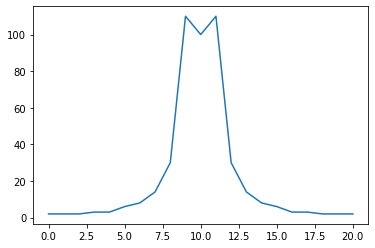

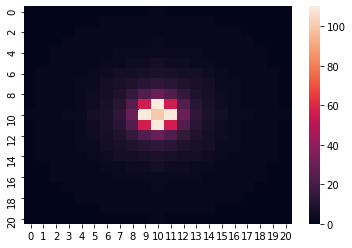

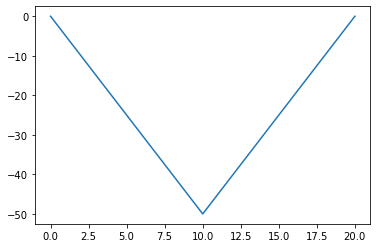

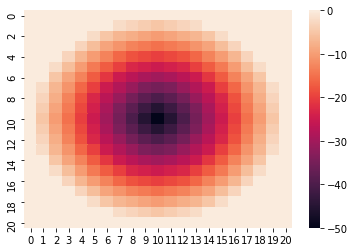

In [265]:
plot_field(repulsion_field(10, scale=10))
show_field(repulsion_field(10, scale=10))
plot_field(attraction_field(10, scale=5))
show_field(attraction_field(10, scale=5))

### Node Dictionaries
 - node_dict objects serve both as
 - an adjacency list form of the network 
 - the structure holding the coordinates

In [163]:
def make_node_dict_from_edge_array(edge_array, sparsity=30, dtype=np.int32, initialize_coordinates=True):
    # for each edge, add the nodes to node_dict, updating the adjancy set
    node_dict = {}
    for edge in edge_array:
        # print(edge[0], " ", edge[1])
        if edge[0] not in node_dict:
            node_dict[edge[0]] = {"adj":set()}
        node_dict[edge[0]]["adj"].add(edge[1])
        node_dict[edge[0]]["degree"] = len(node_dict[edge[0]]["adj"])
        if edge[1] not in node_dict:
            node_dict[edge[1]] = {"adj":set()}
        node_dict[edge[1]]["adj"].add(edge[0])
        node_dict[edge[1]]["degree"] = len(node_dict[edge[1]]["adj"])
            
    gameboard = make_gameboard(len(node_dict), sparsity=sparsity, dtype=dtype)  
    
    # randomly place the nodes in the center of the board
    dimension = gameboard.shape[0]
    temp_board = np.zeros((dimension, dimension))
    center_left = round(dimension/4)
    center_right = dimension - center_left
    if initialize_coordinates:
        for node_id, node in node_dict.items():
            placed = False
            while not placed:
                x = randint(center_left, center_right)
                y = randint(center_left, center_right)
                if temp_board[x, y] == 0:
                    temp_board[x, y] = 1
                    placed = True
            node["x"] = x
            node["y"] = y

    return node_dict, gameboard     

def make_node_dict_from_cx (cx_network, sparsity=30, dtype=np.int32, initialize_coordinates=True):
    edge_array = np.zeros((len(cx_network.get_edges()), 2), dtype=dtype)
    print("edge array: ", edge_array.shape)
    i = 0
    for edge_id, edge in cx_network.get_edges():
        edge_array[i, 0] = edge["s"]
        edge_array[i, 1] = edge["t"]
        i += 1
    node_dict, gameboard = make_node_dict_from_edge_array(edge_array,
                                                          sparsity=sparsity,
                                                          dtype=dtype,
                                                          initialize_coordinates=initialize_coordinates)
    return node_dict, gameboard, edge_array

def make_node_dict_from_cx_old (cx_network, sparsity=30):
    gameboard = make_gameboard(len(cx_network.get_nodes()), sparsity=sparsity)
    dimension = gameboard.shape[0]
    node_dict = {}
    nodes = cx_network.get_nodes()
    for node_id, node in nodes:
        #print(node)
        placed = False
        while not placed:
            x = randint(0,dimension-1)
            y = randint(0,dimension-1)
            if gameboard[x, y] == 0:
                gameboard[x, y] = 1
                placed = True
        node_dict[node_id]= {
            'x' : x,
            'y' : y,
            'adj' : set()
       }
    for edge_id, edge in cx_network.get_edges():
        #print(edge)
        node_dict[edge["s"]]['adj'].add(edge['t'])
        node_dict[edge["t"]]['adj'].add(edge['s'])
    return node_dict, gameboard



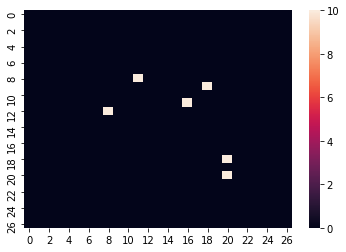

{'foo': {'adj': {'bar', 'baz', 'fred'}, 'degree': 3, 'x': 8, 'y': 11},
 'bar': {'adj': {'baz', 'foo'}, 'degree': 2, 'x': 18, 'y': 20},
 'baz': {'adj': {'bar', 'foo'}, 'degree': 2, 'x': 11, 'y': 16},
 'fred': {'adj': {'alice', 'foo', 'jane'}, 'degree': 3, 'x': 9, 'y': 18},
 'jane': {'adj': {'fred'}, 'degree': 1, 'x': 12, 'y': 8},
 'alice': {'adj': {'fred'}, 'degree': 1, 'x': 20, 'y': 20}}

In [108]:
test_edges_1 = [
    ["foo", "bar"], 
    ["foo", "baz"],
    ["bar", "baz"],
    ["foo", "fred"],
    ["fred", "jane"],
    ["fred", "alice"]
]

test_node_dict_1, test_gameboard_1 = make_node_dict_from_edge_array(test_edges_1)
for node_id, node in test_node_dict_1.items():
    test_gameboard_1[node["x"], node["y"]]=10

show_field(test_gameboard_1)
test_node_dict_1

In [164]:
# Adding fields:
# The two fields are combined at an x-y offset, destructively modifying the target field
# It is neccessary to crop the added field to fit within the target field
def add_field(source_field, target_field, x, y, remove=False, show_node_dict=False):
    if show_node_dict: print("node_dict", x,y)
    target_x_max = target_field.shape[0] - 1
    target_y_max = target_field.shape[1] - 1
    source_x_max = source_field.shape[0] - 1
    source_y_max = source_field.shape[1] - 1
    #
    #   0.0 1.0 2.0
    #   0.1 1.1 2.1
    #   0.2 1.2 2.2
    #
    x_offset = int(source_field.shape[0]/2)
    y_offset = int(source_field.shape[1]/2)
    #print("gb shape", target_field.shape)
    #print("rf offset", x_offset, y_offset)
    target_top_x = x - x_offset
    target_top_y = y - y_offset
    target_bottom_x = x + x_offset
    target_bottom_y = y + y_offset
    #print("gb target", target_top_x,target_top_y,target_bottom_x,target_bottom_y)
    source_top_x = 0
    source_top_y = 0
    source_bottom_x = source_x_max
    source_bottom_y = source_y_max
    #print("rf source", source_top_x,source_top_y,source_bottom_x,source_bottom_y)
    # trim if source_field goes off board negative
    if target_top_x < 0:
        #print("negative x")
        source_top_x = -target_top_x
        target_top_x = 0        
    if target_top_y < 0:
        #print("negative y")
        source_top_y = -target_top_y
        target_top_y = 0
    # trim if source_field goes off board positive
    if target_bottom_x > target_x_max:
        dx = target_bottom_x - target_x_max
        #print("positive x", dx)
        target_bottom_x = target_x_max
        source_bottom_x = source_x_max - dx
    if target_bottom_y > target_y_max:
        dy = target_bottom_y - target_y_max
        #print("positive y", dy)
        target_bottom_y = target_y_max
        source_bottom_y = source_y_max - dy
    #print("adj gb target", target_top_x,target_top_y,target_bottom_x,target_bottom_y) 
    #print("adj rf source", source_top_x,source_top_y,source_bottom_x,source_bottom_y)
    #gameboard[target_top_x, target_top_y] = 1
    #gameboard[target_bottom_x, target_bottom_y] = 1
    # add the source_field to the target_field
    #print(target_field[target_top_x:target_bottom_x+1, target_top_y:target_bottom_y+1])
    #print(source_field[source_top_x:source_bottom_x+1, source_top_y:source_bottom_y+1])
    if remove:
        target_field[target_top_x:target_bottom_x+1, target_top_y:target_bottom_y+1] -= source_field[source_top_x:source_bottom_x+1, source_top_y:source_bottom_y+1]
    else:
        target_field[target_top_x:target_bottom_x+1, target_top_y:target_bottom_y+1] += source_field[source_top_x:source_bottom_x+1, source_top_y:source_bottom_y+1]

# wrapper for readability
def subtract_field(source_field, target_field, x, y, show_node_dict=False):
    add_field(source_field, target_field, x, y, remove=True, show_node_dict=show_node_dict)

# Layout a NiceCX network to create a node_dict
def layout_cx_network(cx_network, rounds=1, sparsity=30, r_radius=4, 
                      a_radius=10, r_scale=10, a_scale=5, center_attractor_scale=0.01,
                     initialize_coordinates=True, dtype=np.int32):
    start = timer()
    node_dict, gameboard, edge_array = make_node_dict_from_cx(cx_network, sparsity=sparsity,
                                                 initialize_coordinates=initialize_coordinates, dtype=dtype)
    end = timer()
    print("make node dict time = ", end - start)
    return layout_node_dict(node_dict, gameboard, rounds=rounds, 
                            r_radius=r_radius, a_radius=a_radius, 
                            r_scale=r_scale, a_scale=a_scale, 
                            center_attractor_scale=center_attractor_scale), gameboard, edge_array

# layout a node_dict, assigning coordinates to each node
def layout_node_dict(node_dict, gameboard, rounds=1, r_radius=10, 
                     a_radius=10, r_scale=10, a_scale=5, 
                     center_attractor_scale=0.01):
    # nodes are pulled towards the center of the gameboard
    # by giving the gameboard an attraction field at its center
    # the radius of the field is the distance from the center to the corners
    center = int(gameboard.shape[0]/2)
    center_attractor_radius = int(math.sqrt(2 * center**2))
    add_field(attraction_field(radius=int(gameboard.shape[0]/2), scale=center_attractor_scale),
              gameboard,
              center, center)
    r_field = repulsion_field(r_radius, scale=r_scale, center_spike=True, dtype=gameboard.dtype)
    a_field = attraction_field(a_radius, scale=a_scale, dtype=gameboard.dtype)
    a_field_med = attraction_field(a_radius, scale=a_scale*5, dtype=gameboard.dtype)
    a_field_high = attraction_field(a_radius, scale=a_scale*30, dtype=gameboard.dtype)
    
    # make a scratchpad board where we add all the attraction fields
    # and the use it to update the gameboard
    s_field = np.zeros(gameboard.shape, gameboard.dtype)
    
    # get the nodes as a list, sorted by degree, highest degree first
    node_list = sorted(node_dict.values(), key=itemgetter('degree'), reverse=True)
    
    # if a node does not have coordinates, don't add its repulsion field
    for node in node_list:  
        if node.get("x"):
            add_field(r_field, gameboard, node["x"], node["y"])
            
    # perform the rounds of layout
    start = timer()
    for n in range(0, rounds):
        # print("round ", n)
        for node in node_list:
            layout_one_node(gameboard, s_field, r_field, a_field, a_field_med, a_field_high, node, node_dict)

    end = timer()
    print("layout time = ", end - start)
    return node_dict

# update the position of one node
def layout_one_node(gb, s_field, source_field, a_field, a_field_med, a_field_high, node, node_dict):
    # clear the scratchpad
    s_field[...]=0
    rank = len(list(node['adj']))     
    for adj_node_id in node['adj']:
        # if the adjacent node has coordinates,
        # add its attraction field to the scratchpad field
        adj_node = node_dict[adj_node_id]
        if adj_node.get("x"):
            if rank == 1:
                add_field(a_field_high, s_field, adj_node["x"], adj_node["y"])
            elif rank < 5:
                add_field(a_field_med, s_field, adj_node["x"], adj_node["y"])
            else:
                add_field(a_field, s_field, adj_node["x"], adj_node["y"])
            
    # add s_field to the gameboard
    gb += s_field
    # if the node has coordinates
    # remove it from the gameboard by subtracting it at its current location
    if node.get("x"):
        subtract_field(source_field, gb, node['x'], node['y'])
    
    # select the destination
    # idea #1: choose a location with the minimum value
    # argmin returns the index of the first location containing the minimum value in a flattened 
    # version of the array
    # unravel_index turns the index back into the coordinates
    destination = np.unravel_index(np.argmin(gb, axis=None), s_field.shape)
    #print(node)
    #print("destination: ", destination)

    # add it at the destination
    add_field(source_field, gb, destination[0], destination[1])
    
    # subtract the s_field to revert the gameboard to just the repulsions
    gb -= s_field
    
    # update the node's coordinates
    node["x"] = destination[0]
    node["y"] = destination[1] 
          

### Testing Field Addition

In [110]:
def test_add_field_positions(small_size=21, large_size=101, dtype=np.int64):
    # large target, small source
    test_add_field_overlaps(small_size, large_size)
    # small target, large source
    test_add_field_overlaps(large_size,small_size)
    
def test_add_field(source_size, target_size, pos="center", dtype=np.int64):
    source = np.ones((source_size, source_size), dtype=dtype) 
    target = np.ones((target_size, target_size), dtype=dtype) 
    target_max_x = target.shape[0]-1
    target_max_y = target.shape[1]-1
    target_center_x = int(target.shape[0]/2)
    target_center_y = int(target.shape[1]/2)
    print(source.shape, target.shape, " ", pos)
    if pos=="top_left":
        add_field(source, target, 0,0)
    elif pos=="bottom_right":      
        add_field(source, target, target_max_x, target_max_y)
    elif pos=="center":
        add_field(source, target, target_center_x, target_center_y)   
    show_field(target)
    
def test_add_field_overlaps(source_size, target_size):
    test_add_field(source_size, target_size, pos="top_left")
    test_add_field(source_size, target_size, pos="bottom_right")
    test_add_field(source_size, target_size, pos="center")

def test_add_field_speed(target_size,  source_size, rounds=1000, target_x=5, target_y=5, dtype=np.int64):
    target_field = np.ones((target_size, target_size), dtype=dtype)
    source_field = np.ones((source_size, target_size), dtype=dtype)
    start = timer()
    for i in range(0, rounds):
        add_field(source_field, target_field, target_x, target_y)
    end = timer()
    elapsed_time = end - start
    rate = elapsed_time / rounds
    print("Elapsed time = ", elapsed_time , " for ", rounds, " rounds. Rate = ", rate, " per round")

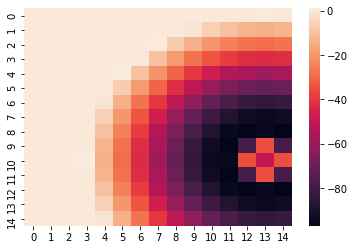

In [111]:
test_gameboard_2 = np.zeros((15, 15), dtype=np.int32)
# add a repulsion field and an attraction field to the gameboard at 10,13
# The fields will go over the boundaries of the gameboard
add_field(repulsion_field(10, scale=10), test_gameboard_2, 10, 13)
add_field(attraction_field(10, scale=15), test_gameboard_2, 10, 13)
show_field(test_gameboard_2)

In [206]:
%prun test_add_field_speed(3001,  15, rounds=40000, target_x=5, target_y=5, dtype=np.int16)

Elapsed time =  0.4516501109901583  for  40000  rounds. Rate =  1.1291252774753957e-05  per round
 

### Testing Layout

layout time =  0.0131862580019515


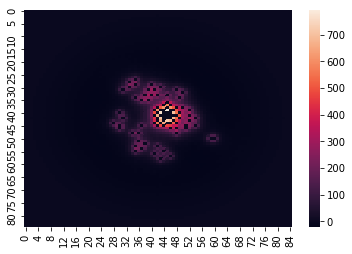

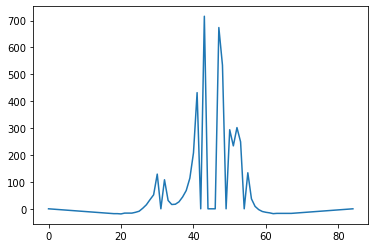

In [116]:
# Converting edges to a numpy array, perform a layout and then show the gameboard
# The cells containing the nodes are set to zero so that the range to plot 
# doesn't contain the repulsion center extreme values.
test_node_dict_3, test_gameboard_3 = make_node_dict_from_edge_array(edges.to_numpy(), 
                                                                    sparsity=20,
                                                                    initialize_coordinates=False,
                                                                    dtype=np.int32
                                                                   )
test_node_dict_3 = layout_node_dict(test_node_dict_3, test_gameboard_3, rounds=2, 
                       r_radius=10, a_radius=10,
                       r_scale=10, a_scale=5, center_attractor_scale=1
                      )
for node_id, node in test_node_dict_3.items():
    test_gameboard_3[node["x"], node["y"]]=0
show_field(test_gameboard_3)
plot_field(test_gameboard_3)
#print(node_dict)

## Layout a network from NDEx and save the modified network. 
- get the network
- do the layout
- show the gameboard
- make a cx layout from the new coordinates in the node_dict
- set it as the layout of the test network
- upload the modified network to NDEx


## Get the network and the edges

In [117]:
nci_pid_tcr_signaling_uuid = "0c2862fa-6196-11e5-8ac5-06603eb7f303"
sonic_hedgehog_uuid = "cfd3528f-a7a4-11eb-9e72-0ac135e8bacf"
nest_uuid = "60112105-f853-11e9-bb65-0ac135e8bacf"
string_hc_uuid = "275bd84e-3d18-11e8-a935-0ac135e8bacf"
cptac_genomic_instability_uuid = "d121e661-4cfc-11e9-9f06-0ac135e8bacf"

test_uuid_4 = cptac_genomic_instability_uuid #nest_uuid
test_network_4 = ndex2.create_nice_cx_from_server(SERVER, uuid=test_uuid_4)
test_network_4.print_summary()



Name: Genome instability and mutation
Nodes: 1043
Edges: 1376
Node Attributes: 7144
Edge Attributes: 6140



edge array:  (1376, 2)
make node dict time =  0.00830996000149753
layout time =  0.1591762219904922


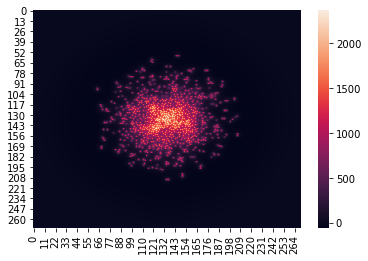

In [118]:
test_node_dict_4, test_gameboard_4 = layout_cx_network(test_network_4, sparsity=20, 
                                                       rounds=1, r_radius= 20, r_scale=20, 
                                                       a_radius=100, a_scale=3,
                                                      center_attractor_scale=1,
                                                      initialize_coordinates=False)
show_field(test_gameboard_4)

In [119]:
test_node_dict_4


{69295: {'adj': {69241}, 'degree': 1, 'x': 121, 'y': 124},
 69241: {'adj': {68262,
   68267,
   68277,
   68284,
   68292,
   68296,
   68302,
   68303,
   68305,
   68312,
   68316,
   68319,
   69265,
   69270,
   69295},
  'degree': 15,
  'x': 123,
  'y': 123},
 69294: {'adj': {69247}, 'degree': 1, 'x': 129, 'y': 165},
 69247: {'adj': {68256, 68299, 68301, 69240, 69258, 69291, 69293, 69294},
  'degree': 8,
  'x': 128,
  'y': 163},
 69293: {'adj': {69247}, 'degree': 1, 'x': 128, 'y': 161},
 69292: {'adj': {69244}, 'degree': 1, 'x': 162, 'y': 174},
 69244: {'adj': {68266, 68269, 69252, 69284, 69292},
  'degree': 5,
  'x': 161,
  'y': 172},
 69291: {'adj': {69247}, 'degree': 1, 'x': 126, 'y': 164},
 69290: {'adj': {69254}, 'degree': 1, 'x': 148, 'y': 101},
 69254: {'adj': {68254, 68258, 68260, 68261, 69239, 69290},
  'degree': 6,
  'x': 149,
  'y': 103},
 69289: {'adj': {69256}, 'degree': 1, 'x': 149, 'y': 123},
 69256: {'adj': {68255,
   68264,
   68265,
   68276,
   68278,
   68282,


### Transform node_dict coordinates into igraph or CX formats

In [120]:
def igraph_layout_from_node_dict(g, node_dict):
    igraph_layout = [(0,0)] * len(node_dict)
    print(len(g.vs), len(node_dict))

    for node_id, node in node_dict.items():
        igraph_node_id = g.vs.find(cx_id=node_id).index
        igraph_layout[igraph_node_id] = (node["x"],node["y"])
    # print(igraph_layout)
    return igraph.Layout(igraph_layout)

def draw_igraph_with_node_dict(g, node_dict):
    l = igraph_layout_from_node_dict(g, node_dict)
    fig, ax = plt.subplots()
    igraph.plot(g, layout=l, target=ax)
    #igraph.plot(g, l)
    
def cx_layout_from_node_dict(node_dict, node_dimension = 40):
    cx_layout = []
    for node_id, node in node_dict.items():
        cx_node = {"node": node_id,
                   "x": node["x"] * node_dimension,
                   "y": node["y"] * node_dimension}
        cx_layout.append(cx_node)
    return cx_layout

In [121]:
new_cx_layout = cx_layout_from_node_dict(test_node_dict_4)
test_network_4.set_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT, new_cx_layout)
new_network_url = test_network_4.upload_to(SERVER, NDEXUSER, NDEXPASSWORD)
new_network_uuid = new_network_url.split('/')[-1]
print("Network's URL (click to view!): " + SERVER + "/viewer/networks/" + new_network_uuid)

Generating CX
Network's URL (click to view!): http://www.ndexbio.org/viewer/networks/621815ba-7705-11ec-b3be-0ac135e8bacf


In [188]:
#test_network_5 = ndex2.create_nice_cx_from_file('nectin-adhesion.cx')
#test_network_5 = ndex2.create_nice_cx_from_file('hierarchy2.cx')
#test_network_5 = ndex2.create_nice_cx_from_file('hnscc_dis.cx')
#test_network_5 = ndex2.create_nice_cx_from_file('MDA231_All_PPI>=0.9.cx')
#test_network_5 = ndex2.create_nice_cx_from_file('budzikhierarchy1.cx')
#test_network_5 = ndex2.create_nice_cx_from_file('bioid_big.cx')
test_network_5 = ndex2.create_nice_cx_from_file('nci_pid_all.cx')


test_network_5.print_summary()


Name: NCI PID - Complete Interactions
Nodes: 2794
Edges: 25296
Node Attributes: 5260
Edge Attributes: 50592



In [256]:
def layout_cx_network_2(cx_network, rounds=1, sparsity=30, r_radius=4, 
                      a_radius=10, r_scale=10, a_scale=5, center_attractor_scale=0.01,
                     initialize_coordinates=True, dtype=np.int32):
    start = timer()
    node_dict, gameboard, edge_array = make_node_dict_from_cx(cx_network, sparsity=sparsity,
                                                 initialize_coordinates=initialize_coordinates, dtype=dtype)
    end = timer()
    print("make node dict time = ", end - start)
    return layout_node_dict_2(node_dict, gameboard, rounds=rounds, 
                            r_radius=r_radius, a_radius=a_radius, 
                            r_scale=r_scale, a_scale=a_scale, 
                            center_attractor_scale=center_attractor_scale), gameboard, edge_array

def add_center_attractor(gameboard, scale):
    # nodes are pulled towards the center of the gameboard
    # by giving the gameboard an attraction field at its center
    # the radius of the field is the distance from the center to the corners
    center = int(gameboard.shape[0]/2)
    center_attractor_radius = int(math.sqrt(2 * center**2))
    attractor = attraction_field(radius=int(gameboard.shape[0]/2), scale=scale)
    add_field(attractor,gameboard, center, center)
    
# layout a node_dict, assigning coordinates to each node
def layout_node_dict_2(node_dict, gameboard, rounds=1, r_radius=10, 
                     a_radius=10, r_scale=10, a_scale=5, 
                     center_attractor_scale=0.01):
   
    add_center_attractor(gameboard, center_attractor_scale)
    r_field = repulsion_field(r_radius, scale=r_scale, center_spike=True, dtype=gameboard.dtype)
    a_field = attraction_field(a_radius, scale=a_scale, dtype=gameboard.dtype)
    a_field_med = attraction_field(a_radius, scale=a_scale, dtype=gameboard.dtype)
    a_field_high = attraction_field(a_radius, scale=a_scale*10, dtype=gameboard.dtype)
    
    # make a scratchpad board where we add all the attraction fields
    # and the use it to update the gameboard
    s_field = np.zeros(gameboard.shape, gameboard.dtype)
    
    # get the nodes as a list, sorted by degree, highest degree first
    node_list = sorted(node_dict.values(), key=itemgetter('degree'), reverse=True)
    
    # if a node does not have coordinates, don't add its repulsion field
    for node in node_list:  
        if node.get("x"):
            add_field(r_field, gameboard, node["x"], node["y"])
            
    # perform the rounds of layout
    start = timer()
    number_of_nodes = len(node_list)
    nodes_per_round = int(number_of_nodes/rounds)
    for n in range(1, rounds+1):
        if n < rounds:
            nodes_this_round = nodes_per_round * n
        else:
            nodes_this_round = number_of_nodes
        print("nodes this round = ", nodes_this_round)
        for i in range(0, nodes_this_round):
            node = node_list[i]
            layout_one_node_2(gameboard, s_field, r_field, a_field, a_field_med, a_field_high, node, node_dict)

    end = timer()
    print("layout time = ", end - start)
    return node_dict

# update the position of one node
def layout_one_node_2(gb, s_field, source_field, a_field, a_field_med, a_field_high, node, node_dict):
    # clear the scratchpad
    s_field[...]=0
    degree = math.log(node['degree'], 2)   
    for adj_node_id in node['adj']:
        # if the adjacent node has coordinates,
        # add its attraction field to the scratchpad field
        adj_node = node_dict[adj_node_id]
        if adj_node.get("x"):
            if degree < 2:
                add_field(a_field_high, s_field, adj_node["x"], adj_node["y"])
            #elif degree < 2:
            #    add_field(a_field_med, s_field, adj_node["x"], adj_node["y"])
            else:
                add_field(a_field, s_field, adj_node["x"], adj_node["y"])
            
    # add s_field to the gameboard
    gb += s_field
    # if the node has coordinates
    # remove it from the gameboard by subtracting it at its current location
    if node.get("x"):
        subtract_field(source_field, gb, node['x'], node['y'])
    
    # select the destination
    # idea #1: choose a location with the minimum value
    # argmin returns the index of the first location containing the minimum value in a flattened 
    # version of the array
    # unravel_index turns the index back into the coordinates
    destination = np.unravel_index(np.argmin(gb, axis=None), s_field.shape)
    #print(node)
    #print("destination: ", destination)

    # add it at the destination
    add_field(source_field, gb, destination[0], destination[1])
    
    # subtract the s_field to revert the gameboard to just the repulsions
    gb -= s_field
    
    # update the node's coordinates
    node["x"] = destination[0]
    node["y"] = destination[1] 

edge array:  (25296, 2)
make node dict time =  0.12374668798292987
nodes this round =  1397
nodes this round =  2794
layout time =  1.3423238709801808
 

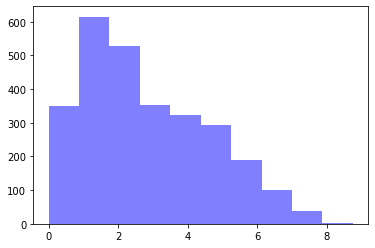

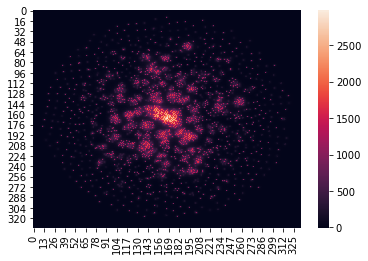

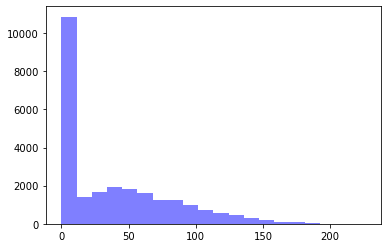

In [266]:
def layout_2(t): 
    return layout_cx_network_2(t,sparsity=10,rounds=2,r_radius=20,r_scale=10,
                               a_radius=10,a_scale=10,center_attractor_scale=1,initialize_coordinates=False,dtype=np.int16)

%prun test_node_dict_5, test_gameboard_5, test_edge_array_5 = layout_2(test_network_5)

degrees=[]
for node in test_node_dict_5.values():
    degrees.append(math.log(node['degree'], 2))
num_bins = 10
n, bins, patches = plt.hist(degrees, num_bins, facecolor='blue', alpha=0.5)
plt.show()

show_field(test_gameboard_5)

distances=[]
for row in test_edge_array_5:
    source = test_node_dict_5[row[0]]
    target = test_node_dict_5[row[1]]
    distance = math.sqrt((source['x'] - target['x'])**2 + (source['y'] - target['y'])**2)
    distances.append(distance)
    
num_bins = 20
n, bins, patches = plt.hist(distances, num_bins, facecolor='blue', alpha=0.5)
plt.show()



In [267]:
new_cx_layout_5 = cx_layout_from_node_dict(test_node_dict_5)
test_network_5.set_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT, new_cx_layout_5)
test_network_5.print_summary()
upload=True
if upload:
    print("starting upload")
    start=timer()
    new_network_url_5 = test_network_5.upload_to(SERVER, NDEXUSER, NDEXPASSWORD)
    end=timer()
    print("upload time = ", end - start)
    new_network_uuid_5 = new_network_url_5.split('/')[-1]
    print("Network's URL (click to view!): " + SERVER + "/viewer/networks/" + new_network_uuid_5)
else:
    display_cx = test_network_5.to_cx()
    Cytoscape(data=test_network_5.to_cx(), format='cx')

Name: NCI PID - Complete Interactions
Nodes: 2794
Edges: 25296
Node Attributes: 5260
Edge Attributes: 50592

starting upload
Generating CX
upload time =  5.276256849989295
Network's URL (click to view!): http://www.ndexbio.org/viewer/networks/ecdc517e-77cf-11ec-b3be-0ac135e8bacf


In [159]:
def igraph_from_nice_cx(nice_cx):
    g = igraph.Graph(len(nice_cx.get_nodes()))
    # network attributes
    for name in nice_cx.get_network_attribute_names():
        value = nice_cx.get_network_attribute(name)["v"]
        #print(value)
        g[name]=value      
    # attribute declarations
    # nodes and attributes and coordinates
    # make a node_id list
    node_id_list = []
    n_id = 0
    for node_id, node in nice_cx.get_nodes():
        g.vs[n_id]["cx_id"] = node_id
        #atts = nice_cx.get_node_attributes(node_id)
        #for att in atts:
        #    att_name = att["n"]
        #    att_value = att["v"]
        #    g.vs[n_id][att_name] = att_value
        n_id += 1
        
    # edges and attributes
    for edge_id, edge in nice_cx.get_edges():
        cx_source_id = edge["s"]
        cx_target_id = edge["t"]
        g_source = g.vs.find(cx_id=cx_source_id)
        g_target = g.vs.find(cx_id=cx_target_id)
        g.add_edges([(g_source, g_target)])
        #e_id = g.get_eid(g_source, g_target)
        #g.es[e_id]["cx_id"] = edge_id
        #atts = nice_cx.get_edge_attributes(node_id)
        #for att in atts:
        #    att_name = att["n"]
         #   att_value = att["v"]
         #   g.es[e_id][att_name] = att_value

    # cartesian coordinates
    g["cartesian_layout"] = nice_cx.get_opaque_aspect(ndex2.constants.CARTESIAN_LAYOUT_ASPECT)
    #visual styles
    # bypasses
    # rules
    return g

In [160]:
g1 = igraph_from_nice_cx(test_network_5)
g1